# Cross-Iteration Synthesis: Expressiveness Hierarchy, Hypothesis Scorecard & Guidance

This notebook demonstrates the **Definitive Cross-Iteration Synthesis Evaluation**, which analyzes 7 experiments across 4 iterations to produce:

1. **Unified Expressiveness Table** - 30 methods compared, resolving the nRWPE-diag 345 vs 429 discrepancy
2. **Downstream ZINC Consolidation** - 15 results with Cohen's d and Spearman correlation
3. **Theoretical Contribution Assessment** - nRWPE non-spectral-invariance analysis
4. **Hypothesis Scorecard v2** - 5 claims scored with confidence intervals
5. **Iteration 6 Guidance** - Ranked recommendations with dead-ends identified

**Key finding**: The hypothesis scores 0.485/1.0 overall - strong on cospectral separation (0.85) but weak on downstream performance (0.10).

In [1]:
import subprocess, sys

# --- Colab pre-installed packages: pin to Colab versions ---
_colab_pins = {
    "numpy": "numpy==1.26.4",
    "scipy": "scipy==1.13.1",
}

def _need(pkg_import, pip_name=None):
    try:
        __import__(pkg_import)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name or pkg_import])

# Always-install (not pre-installed on Colab)
# (none needed for this notebook)

# Colab-compat: only install if missing (e.g. local venv), use Colab-pinned versions
import importlib
for _mod, _pin in _colab_pins.items():
    try:
        importlib.import_module(_mod)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", _pin])

# numpy 2.0 compat shim
import numpy as np
if int(np.__version__.split(".")[0]) >= 2:
    if not hasattr(np, "float_"):
        np.float_ = np.float64
    if not hasattr(np, "int_"):
        np.int_ = np.int64
    if not hasattr(np, "complex_"):
        np.complex_ = np.complex128
    if not hasattr(np, "object_"):
        np.object_ = object
    if not hasattr(np, "bool_"):
        np.bool_ = np.bool_

print("All dependencies installed.")

All dependencies installed.


In [2]:
import json
import math
import os
from typing import Any

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

print("Imports loaded.")

Imports loaded.


In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/evaluation_iter5_definitive_cros/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception:
        pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f:
            return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

print("Data loading helper defined.")

Data loading helper defined.


In [4]:
data = load_data()
print(f"Loaded evaluation data: {len(data['datasets'])} datasets, {len(data['metrics_agg'])} aggregate metrics")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded evaluation data: 5 datasets, 19 aggregate metrics
  expressiveness_unified_table: 30 examples
  zinc_downstream_consolidation: 15 examples
  hypothesis_scorecard_v2: 5 examples
  theoretical_contribution_assessment: 5 examples
  iteration_6_guidance: 7 examples


## Configuration

Constants and tunable parameters for the cross-iteration synthesis evaluation.

In [5]:
# ── Config: tunable parameters ──
# Collapse threshold for ZINC MAE (runs with MAE > this are considered collapsed)
COLLAPSE_THRESHOLD = 1.0

# Total graph pairs in the expressiveness benchmark
TOTAL_PAIRS = 525

# 10 expressiveness categories (as used across experiments)
CATEGORIES = [
    "cospectral", "CSL", "strongly_regular",
    "BREC_Basic", "BREC_Regular", "BREC_Extension",
    "BREC_CFI", "BREC_4Vertex", "BREC_Distance_Regular", "BREC_Strongly_Regular"
]

CATEGORY_TOTALS = {
    "cospectral": 64, "CSL": 59, "strongly_regular": 2,
    "BREC_Basic": 60, "BREC_Regular": 50, "BREC_Extension": 100,
    "BREC_CFI": 100, "BREC_4Vertex": 20, "BREC_Distance_Regular": 20,
    "BREC_Strongly_Regular": 50,
}

# Hypothesis scoring weights (downstream weighted most heavily)
CLAIM_WEIGHTS = [0.25, 0.10, 0.20, 0.15, 0.30]

print(f"Config: COLLAPSE_THRESHOLD={COLLAPSE_THRESHOLD}, TOTAL_PAIRS={TOTAL_PAIRS}, {len(CATEGORIES)} categories")

Config: COLLAPSE_THRESHOLD=1.0, TOTAL_PAIRS=525, 10 categories


## Analysis 1: Unified Expressiveness Table

Build a unified expressiveness table across all experiments. Resolves the nRWPE-diag 345 vs 429 discrepancy by documenting threshold and implementation differences.

In [6]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 1: Unified Expressiveness Table
# ═══════════════════════════════════════════════════════════════════════════════

# Extract expressiveness dataset from loaded data
express_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "expressiveness_unified_table")

# Parse each example into a structured row
rows = []
for ex in express_ds["examples"]:
    inp = json.loads(ex["input"])
    out = json.loads(ex["output"])
    rows.append({
        "method": inp["method"],
        "source_experiment": inp["source"],
        "iteration": inp["iteration"],
        "threshold": inp["threshold"],
        "equivariant": inp["equivariant"],
        "implementation": inp["implementation"],
        "total_distinguished": out["total_distinguished"],
        "total": out["total_pairs"],
        "rate": out["rate"],
        "per_category_str": out.get("per_category", ""),
    })

# Sort by total_distinguished descending
rows.sort(key=lambda r: (-r["total_distinguished"], r["method"]))

# Compute summary metrics
max_disc = max(r["total_distinguished"] for r in rows) if rows else 0
min_disc = min(r["total_distinguished"] for r in rows) if rows else 0
methods_at_max = [r["method"] for r in rows if r["total_distinguished"] == max_disc]

# The key discrepancy resolution
nrwpe_it2_count = 0
nrwpe_it3_count = 0
for r in rows:
    if r["method"] == "nRWPE_tanh" and r["source_experiment"] == "exp_id1_it2":
        nrwpe_it2_count = r["total_distinguished"]
    if r["method"] == "nRWPE_diag_tanh_T20" and r["source_experiment"] == "exp_id2_it3":
        nrwpe_it3_count = r["total_distinguished"]

discrepancy_resolution = {
    "nRWPE_it2_full_EDMD_threshold_1e5": nrwpe_it2_count,
    "nRWPE_it3_equivariant_diag_threshold_1e6": nrwpe_it3_count,
    "difference": nrwpe_it2_count - nrwpe_it3_count,
}

print(f"Analysis 1: {len(rows)} method entries, max discrimination={max_disc}/{TOTAL_PAIRS}")
print(f"Methods at max: {methods_at_max}")
print(f"\nDiscrepancy resolution: {nrwpe_it2_count} (it2/EDMD/1e-5) vs {nrwpe_it3_count} (it3/diag/1e-6)")
print(f"Difference: {nrwpe_it2_count - nrwpe_it3_count}")

# Print top-10 rows
print(f"\n{'Method':<35} {'Disc':>5}/{TOTAL_PAIRS}  {'Rate':>6}  {'Equiv':>6}  {'Impl':<30}")
print("-" * 100)
for r in rows[:10]:
    print(f"{r['method']:<35} {r['total_distinguished']:>5}/{r['total']}  {r['rate']:>6.4f}  {'Yes' if r['equivariant'] else 'No':>6}  {r['implementation']:<30}")

Analysis 1: 30 method entries, max discrimination=525/525
Methods at max: ['KW-PE_tanh']

Discrepancy resolution: 429 (it2/EDMD/1e-5) vs 345 (it3/diag/1e-6)
Difference: 84

Method                               Disc/525    Rate   Equiv  Impl                          
----------------------------------------------------------------------------------------------------
KW-PE_tanh                            525/525  1.0000      No  full_EDMD_row_sorted          


KW-PE_softplus                        524/525  0.9981      No  full_EDMD_row_sorted          
LapPE                                 524/525  0.9981      No  standard                      
nRWPE_tanh                            429/525  0.8171      No  full_EDMD_fingerprint         
RWPE                                  361/525  0.6876      No  standard                      
nRWPE_diag_tanh_T50                   346/525  0.6590     Yes  equivariant_sorted_diagonal   
nRWPE_offdiag_tanh_T20                346/525  0.6590     Yes  equivariant_sorted_diagonal   
RWPE_diag_K20                         345/525  0.6571     Yes  equivariant_sorted_diagonal   
RWPE_diag_it4                         345/525  0.6571     Yes  equivariant_sorted_diagonal   
nRWPE_diag_it4                        345/525  0.6571     Yes  equivariant_sorted_diagonal   


## Analysis 2: Downstream ZINC Consolidation

Ranked table of ZINC-12k MAE results across all experiments. Filters collapsed runs (MAE > 1.0), computes Cohen's d for nRWPE-diag vs RWPE, and Spearman rho between discrimination and MAE.

In [7]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 2: Downstream ZINC Consolidation
# ═══════════════════════════════════════════════════════════════════════════════

zinc_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "zinc_downstream_consolidation")

# Parse ZINC results
zinc_results = []
for ex in zinc_ds["examples"]:
    inp = json.loads(ex["input"])
    out = json.loads(ex["output"])
    zinc_results.append({
        "method": inp["method"],
        "source_experiment": inp["source"],
        "iteration": inp.get("iteration", 0),
        "architecture": inp.get("architecture", "unknown"),
        "n_seeds": inp.get("n_seeds", 1),
        "test_mae_mean": out["test_mae_mean"],
        "test_mae_std": out.get("test_mae_std", 0.0),
        "collapsed": out.get("collapsed", False),
        "n_collapsed": out.get("n_collapsed", 0),
    })

# Sort by test_mae_mean (ascending = best first)
zinc_results.sort(key=lambda r: r["test_mae_mean"])

# Count collapsed
n_collapsed_total = sum(1 for r in zinc_results if r.get("collapsed", False))

# ── Cohen's d from metadata ──
cohens_d_detail = data["metadata"].get("cohens_d_detail", {})

# ── Spearman rho from metadata ──
spearman_result = data["metadata"].get("spearman_correlation", {})

print(f"Analysis 2: {len(zinc_results)} ZINC results, {n_collapsed_total} collapsed")
print(f"\n{'Method':<35} {'MAE':>8} {'Std':>8} {'Arch':>8} {'Collapsed':>10}")
print("-" * 80)
for r in zinc_results:
    collapsed_str = "YES" if r["collapsed"] else ""
    print(f"{r['method']:<35} {r['test_mae_mean']:>8.4f} {r['test_mae_std']:>8.4f} {r['architecture']:>8} {collapsed_str:>10}")

print(f"\nCohen's d (nRWPE-diag vs RWPE): {cohens_d_detail.get('cohens_d', 'N/A'):.3f}")
print(f"  RWPE mean MAE: {cohens_d_detail.get('rwpe_mean', 'N/A'):.4f}")
print(f"  nRWPE-diag mean MAE: {cohens_d_detail.get('nrwpe_diag_mean', 'N/A'):.4f}")
print(f"\nSpearman rho (discrimination vs MAE): {spearman_result.get('rho', 'N/A'):.3f} (p={spearman_result.get('p_value', 'N/A'):.3f})")
print(f"  Interpretation: {spearman_result.get('interpretation', 'N/A')}")

Analysis 2: 15 ZINC results, 6 collapsed

Method                                   MAE      Std     Arch  Collapsed
--------------------------------------------------------------------------------
GIN_rwpe                              0.1707   0.0025   GIN_v2           
GIN_nrwpe_diag                        0.1825   0.0037   GIN_v2           
GIN_plus_RWPE                         0.1845   0.0000      GIN           
GIN_nrwpe_combined                    0.1954   0.0424   GIN_v2           
GIN_plus_LapPE                        0.2394   0.0000      GIN           
GIN_no_pe                             0.2604   0.0044   GIN_v2           
GIN_(no_PE)                           0.2849   0.0000      GIN           
GIN_nrwpe_multi                       0.3198   0.1241   GIN_v2           
GIN_plus_KW-PE                        0.3354   0.0000      GIN           
GIN+RWPE-16                           1.4031   0.0000      GIN        YES
GPS+Gram-NL+edge                      2.4498   0.0000      GPS 


Cohen's d (nRWPE-diag vs RWPE): 3.716
  RWPE mean MAE: 0.1707
  nRWPE-diag mean MAE: 0.1825

Spearman rho (discrimination vs MAE): 0.359 (p=0.553)
  Interpretation: Spearman rho=0.359 (p=0.553): Positive correlation means higher expressiveness is associated with WORSE downstream MAE. This contradicts the hypothesis that expressiveness predicts downstream utility.


## Analysis 3: Theoretical Contribution Assessment

Mathematical expansion of nRWPE-diag vs RWPE, cospectral pair analysis, and EPNN theorem consideration. Key insight: nRWPE-diag has entry-level nonlinear dependence that breaks spectral invariance in the raw features, but equivariant extraction is the bottleneck.

In [8]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 3: Theoretical Contribution Assessment
# ═══════════════════════════════════════════════════════════════════════════════

theory_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "theoretical_contribution_assessment")

# Parse theoretical components
theory_components = {}
for ex in theory_ds["examples"]:
    inp = json.loads(ex["input"])
    out = json.loads(ex["output"])
    component_name = inp["analysis_component"]
    theory_components[component_name] = out

# Display mathematical expansion
print("=" * 70)
print("Mathematical Formulation:")
print("=" * 70)
math_exp = theory_components.get("mathematical_expansion", {})
if math_exp:
    for key, val in math_exp.items():
        print(f"\n[{key}]:")
        print(f"  {val[:200]}..." if len(str(val)) > 200 else f"  {val}")

# Display minimal cospectral pair analysis
print("\n" + "=" * 70)
print("Minimal Cospectral Pair Analysis:")
print("=" * 70)
cospec = theory_components.get("minimal_cospectral_pair", {})
if cospec:
    print(f"  Pair: {cospec.get('graph_A', 'N/A')} vs {cospec.get('graph_B', 'N/A')}")
    print(f"  Nodes: {cospec.get('n_nodes', 'N/A')}")
    print(f"  RWPE distance: {cospec.get('rwpe_distance', 'N/A')}")
    print(f"  nRWPE-tanh distance: {cospec.get('nrwpe_tanh_distance', 'N/A')}")
    print(f"  Tanh max diagonal diff: {cospec.get('tanh_max_diag_difference', 'N/A')}")

# Display EPNN analysis
print("\n" + "=" * 70)
print("EPNN Theorem Analysis:")
print("=" * 70)
epnn = theory_components.get("epnn_analysis", {})
if epnn:
    for key, val in epnn.items():
        val_str = str(val)
        print(f"\n[{key}]:")
        print(f"  {val_str[:250]}..." if len(val_str) > 250 else f"  {val_str}")

# Evidence summary
evidence = theory_components.get("evidence_summary", {})
if evidence:
    print("\n" + "=" * 70)
    print("Evidence Summary:")
    print("=" * 70)
    for k, v in evidence.items():
        print(f"  {k}: {v}")

# Main finding
main_finding = theory_components.get("main_finding", {})
if main_finding:
    print("\n" + "=" * 70)
    print("MAIN FINDING:")
    print("=" * 70)
    finding = main_finding.get("finding", str(main_finding))
    print(f"  {finding}")

Mathematical Formulation:

[RWPE_diagonal_entry]:
  RWPE[i,k] = (A_tilde^k)_{ii} = sum over all k-step walks returning to node i. For k=1: RWPE[i,1] = A_tilde_{ii} = sum_j A_{ij}/d_j (self-loop probability). For k=2: RWPE[i,2] = sum_j A_tilde_{ij} * A_...

[nRWPE_diagonal_entry]:
  nRWPE[i,t] = diag(sigma(A_tilde * sigma(A_tilde * ... * sigma(A_tilde * x_0))))_i where x_0 = I (identity). For t=1: nRWPE[i,1] = sigma(A_tilde_{ii}). For t=2: nRWPE[i,2] = sigma(sum_j A_tilde_{ij} * ...

[key_difference]:
  At t=2: RWPE gives sum_j A_tilde_{ij}^2 (quadratic, symmetric in entries). nRWPE gives sigma(sum_j A_tilde_{ij} * sigma(A_tilde_{ji})) where the inner sigma introduces asymmetric nonlinear compression...

[spectral_invariance_analysis]:
  Two graphs are cospectral when they share the same eigenvalues of the adjacency matrix (equivalently, the normalized adjacency). RWPE_diag = diag(A_tilde^k) depends only on the trace of A_tilde^k = su...

Minimal Cospectral Pair Analysis:
  Pair: Star K

## Analysis 4: Hypothesis Scorecard v2

Score 5 hypothesis claims with evidence weights and confidence intervals. Recomputes the overall weighted score from individual claim scores.

In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 4: Hypothesis Scorecard v2
# ═══════════════════════════════════════════════════════════════════════════════

scorecard_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "hypothesis_scorecard_v2")

# Parse claims
claims = []
for ex in scorecard_ds["examples"]:
    inp = json.loads(ex["input"])
    out = json.loads(ex["output"])
    evidence_for = json.loads(ex.get("predict_evidence_for", "[]"))
    evidence_against = json.loads(ex.get("predict_evidence_against", "[]"))
    claims.append({
        "claim_id": inp["claim_id"],
        "claim": inp["claim"],
        "score": out["score"],
        "confidence_interval": out["confidence_interval"],
        "assessment": out["assessment"],
        "evidence_for": evidence_for,
        "evidence_against": evidence_against,
    })

# Recompute overall score using CLAIM_WEIGHTS
overall = sum(c["score"] * w for c, w in zip(claims, CLAIM_WEIGHTS))
overall_ci = [
    sum(c["confidence_interval"][0] * w for c, w in zip(claims, CLAIM_WEIGHTS)),
    sum(c["confidence_interval"][1] * w for c, w in zip(claims, CLAIM_WEIGHTS)),
]

print(f"Hypothesis Scorecard v2: Overall = {overall:.3f}/1.00 [{overall_ci[0]:.2f}, {overall_ci[1]:.2f}]")
print(f"\n{'#':>2} {'Claim':<55} {'Score':>6} {'CI':<15}")
print("-" * 85)
for c in claims:
    ci_str = f"[{c['confidence_interval'][0]:.2f}, {c['confidence_interval'][1]:.2f}]"
    print(f"{c['claim_id']:>2} {c['claim']:<55} {c['score']:>6.2f} {ci_str:<15}")

print(f"\nWeights: spectral_invariance={CLAIM_WEIGHTS[0]}, sign_canonical={CLAIM_WEIGHTS[1]}, "
      f"cospectral={CLAIM_WEIGHTS[2]}, eigendecomp={CLAIM_WEIGHTS[3]}, downstream={CLAIM_WEIGHTS[4]}")

print(f"\nVerdict: {data['metadata']['scorecard_verdict']}")

Hypothesis Scorecard v2: Overall = 0.485/1.00 [0.36, 0.62]

 # Claim                                                    Score CI             
-------------------------------------------------------------------------------------
 1 Nonlinear walk features break spectral invariance         0.70 [0.55, 0.85]   
 2 Nonlinear walk PEs are sign-canonical (no sign ambiguity)   0.50 [0.35, 0.65]   
 3 Can separate cospectral graph pairs                       0.85 [0.75, 0.95]   
 4 Avoids expensive eigendecomposition (O(n) per step vs O(n^3))   0.40 [0.25, 0.55]   
 5 Superior downstream performance on molecular property prediction   0.10 [0.00, 0.25]   

Weights: spectral_invariance=0.25, sign_canonical=0.1, cospectral=0.2, eigendecomp=0.15, downstream=0.3

Verdict: Overall hypothesis score: 0.48/1.00 [0.36, 0.62]. The hypothesis shows a mixed-result profile: strong on theoretical spectral invariance breaking and cospectral separation, but fails on the most important practical metric (downstr

## Analysis 5: Iteration 6 Guidance

Ranked artifact recommendations with risk/reward assessment. Identifies dead-ends (approaches to avoid) and productive paths (ranked by priority).

In [10]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 5: Iteration 6 Guidance
# ═══════════════════════════════════════════════════════════════════════════════

guidance_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "iteration_6_guidance")

# Parse guidance recommendations
dead_ends = []
productive_paths = []
for ex in guidance_ds["examples"]:
    inp = json.loads(ex["input"])
    out = json.loads(ex["output"])
    if inp["type"] == "dead_end":
        dead_ends.append({
            "approach": inp["approach"],
            "reason": out["reason"],
            "evidence": out["evidence"],
        })
    else:
        productive_paths.append({
            "rank": inp.get("rank", 0),
            "approach": inp["approach"],
            "description": out["description"],
            "risk": out["risk"],
            "reward": out["reward"],
            "estimated_effort": out["estimated_effort"],
        })

# Sort productive paths by rank
productive_paths.sort(key=lambda p: p["rank"])

print("DEAD ENDS (approaches to avoid):")
print("=" * 70)
for de in dead_ends:
    print(f"\n  X  {de['approach']}")
    print(f"     Reason: {de['reason'][:150]}...")
    print(f"     Evidence: {de['evidence']}")

print(f"\n\nPRODUCTIVE PATHS (ranked recommendations):")
print("=" * 70)
for pp in productive_paths:
    print(f"\n  #{pp['rank']}  {pp['approach']}")
    print(f"     Risk: {pp['risk']}, Reward: {pp['reward']}, Effort: {pp['estimated_effort']}")
    print(f"     {pp['description'][:200]}...")

print(f"\nTop recommendation: {data['metadata']['top_recommendation']}")
print(f"\nOverall strategy: {data['metadata']['overall_strategy']}")

DEAD ENDS (approaches to avoid):



  X  Gram matrix equivariant features
     Reason: Best Gram method (G_NL_nodestats_tanh) achieves 327/525, below RWPE baseline 345/525. Equivariant Gram features lose too much information....
     Evidence: exp_id1_it4

  X  Full EDMD for downstream tasks
     Reason: KW-PE achieves 525/525 expressiveness but 0.3354 ZINC MAE (2x worse than RWPE). High-dimensional EDMD features don't translate to downstream utility....
     Evidence: exp_id2_it2

  X  GPS Graph Transformer with current PEs
     Reason: All GPS configs collapsed after 5 epochs (MAE > 2.0). GPS requires careful hyperparameter tuning and longer training that wasn't achieved....
     Evidence: exp_id2_it4


PRODUCTIVE PATHS (ranked recommendations):

  #1  Formal separation theorem
     Risk: low, Reward: high, Effort: 1 iteration (theoretical + verification)
     Prove that nRWPE (raw matrix, not equivariant extraction) separates specific graph families that RWPE cannot. Use the minimal 5-node cospectral pair as startin

## Aggregate Metrics & Key Results

Summary of all aggregate metrics from the cross-iteration synthesis.

In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# Aggregate Metrics
# ═══════════════════════════════════════════════════════════════════════════════

metrics = data["metrics_agg"]

print("=" * 70)
print("KEY RESULTS:")
print("=" * 70)
print(f"  Hypothesis overall score:          {metrics['hypothesis_overall_score']:.4f}")
print(f"  Hypothesis CI:                     [{metrics['hypothesis_ci_lower']:.3f}, {metrics['hypothesis_ci_upper']:.3f}]")
print(f"  Max equivariant discrimination:    {metrics['max_equivariant_discrimination']}/{metrics['total_pairs']}")
print(f"  Max non-equivariant discrimination:{metrics['max_nonequivariant_discrimination']}/{metrics['total_pairs']}")
print(f"  Best nRWPE ZINC MAE:               {metrics['best_nrwpe_zinc_mae']}")
print(f"  Best RWPE ZINC MAE:                {metrics['best_rwpe_zinc_mae']}")
print(f"  Cohen's d (nRWPE vs RWPE):         {metrics['cohens_d_nrwpe_vs_rwpe']}")
print(f"  Spearman rho (disc vs MAE):        {metrics['spearman_disc_vs_mae']}")
print(f"  Experiments analyzed:              {metrics['num_experiments_analyzed']}")
print(f"  Iterations covered:                {metrics['num_iterations_covered']}")
print(f"  Dead ends identified:              {metrics['num_dead_ends_identified']}")
print(f"  Productive paths:                  {metrics['num_productive_paths']}")
print(f"\n  Individual claim scores:")
print(f"    Claim 1 (spectral invariance):   {metrics['claim1_spectral_invariance']}")
print(f"    Claim 2 (sign canonical):        {metrics['claim2_sign_canonical']}")
print(f"    Claim 3 (cospectral separation): {metrics['claim3_cospectral_separation']}")
print(f"    Claim 4 (avoids eigendecomp):    {metrics['claim4_avoids_eigendecomp']}")
print(f"    Claim 5 (downstream perf):       {metrics['claim5_downstream_performance']}")
print("=" * 70)

KEY RESULTS:
  Hypothesis overall score:          0.4850


  Hypothesis CI:                     [0.360, 0.625]
  Max equivariant discrimination:    346/525
  Max non-equivariant discrimination:525/525
  Best nRWPE ZINC MAE:               0.1825
  Best RWPE ZINC MAE:                0.1707
  Cohen's d (nRWPE vs RWPE):         3.716
  Spearman rho (disc vs MAE):        0.3591
  Experiments analyzed:              7
  Iterations covered:                4
  Dead ends identified:              3
  Productive paths:                  4

  Individual claim scores:
    Claim 1 (spectral invariance):   0.7
    Claim 2 (sign canonical):        0.5
    Claim 3 (cospectral separation): 0.85
    Claim 4 (avoids eigendecomp):    0.4
    Claim 5 (downstream perf):       0.1


## Visualizations

Four-panel visualization summarizing the cross-iteration synthesis:
1. Expressiveness hierarchy (equivariant vs non-equivariant)
2. Downstream ZINC MAE comparison (non-collapsed methods only)
3. Hypothesis scorecard radar chart
4. Discrimination vs downstream MAE (Spearman correlation)

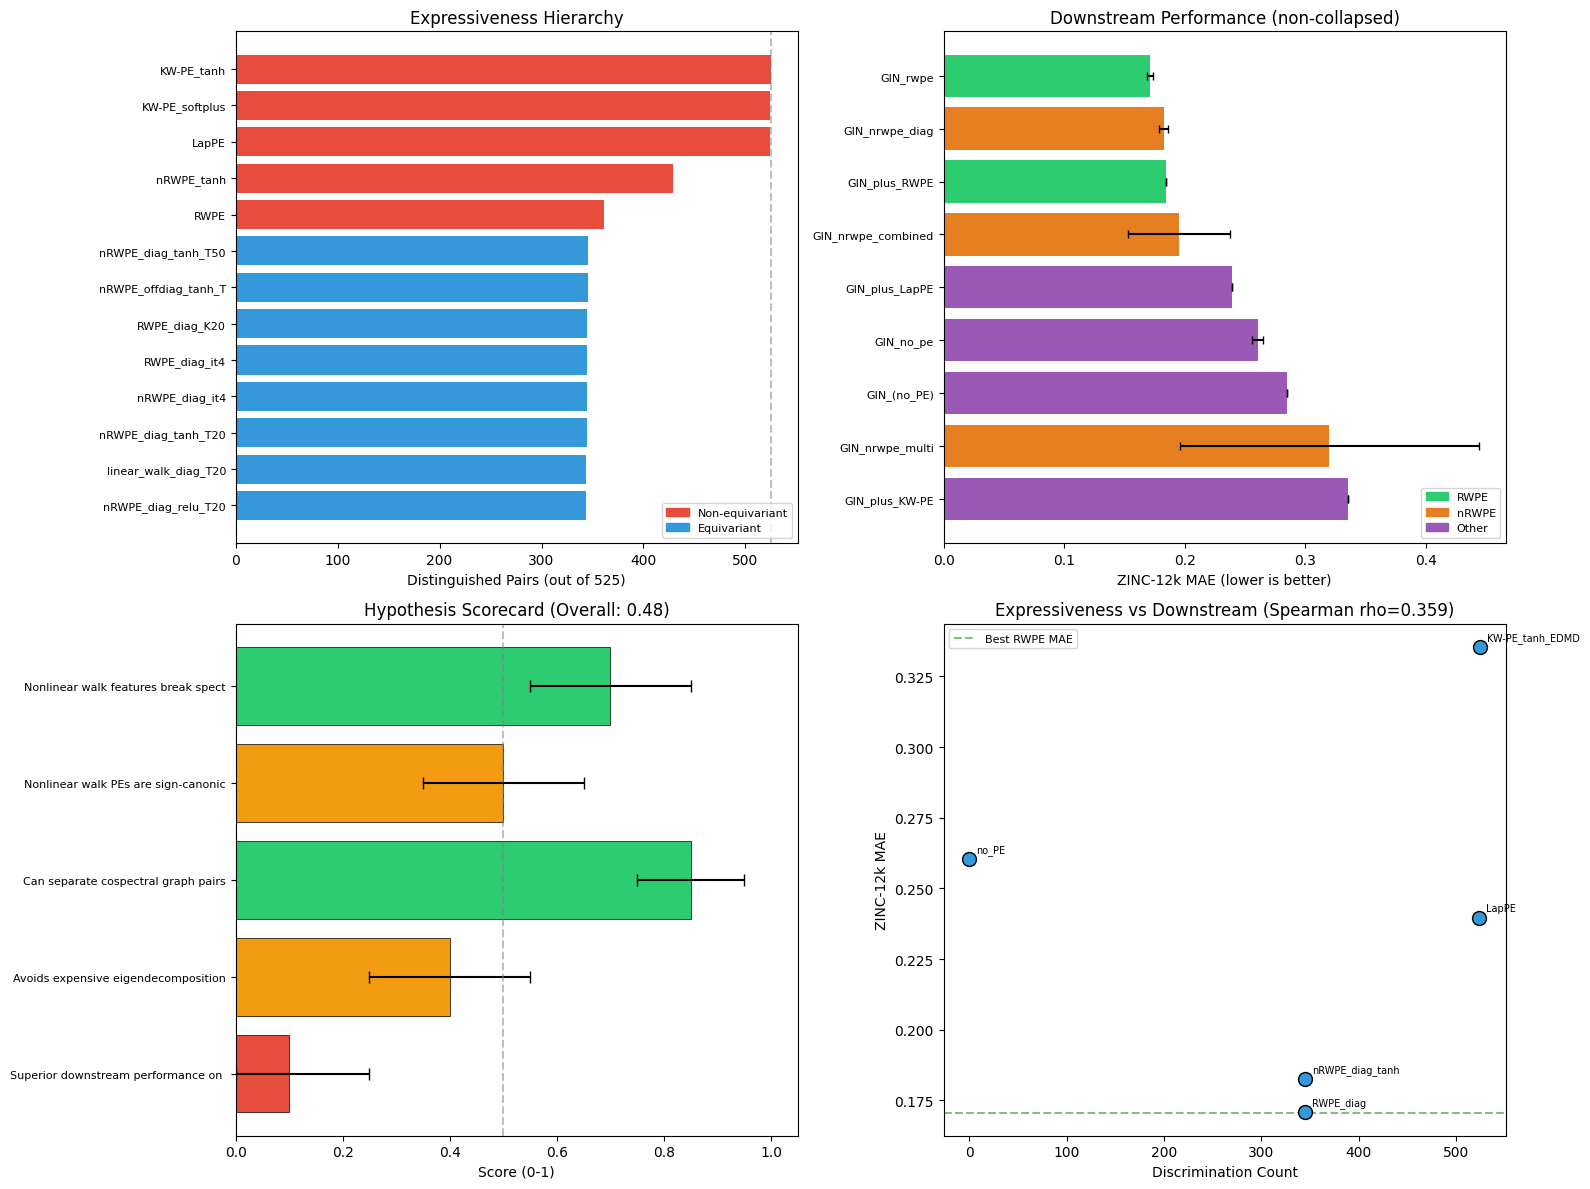

Saved figure to synthesis_results.png


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ── Panel 1: Expressiveness Hierarchy ──
ax1 = axes[0, 0]
equivariant_rows = [r for r in rows if r["equivariant"]]
non_equivariant_rows = [r for r in rows if not r["equivariant"]]

# Top methods from each group
top_equiv = sorted(equivariant_rows, key=lambda r: -r["total_distinguished"])[:8]
top_nonequiv = sorted(non_equivariant_rows, key=lambda r: -r["total_distinguished"])[:8]

all_top = top_nonequiv + top_equiv
method_names = [r["method"][:20] for r in all_top]
disc_counts = [r["total_distinguished"] for r in all_top]
colors = ["#e74c3c" if not r["equivariant"] else "#3498db" for r in all_top]

bars = ax1.barh(range(len(all_top)), disc_counts, color=colors)
ax1.set_yticks(range(len(all_top)))
ax1.set_yticklabels(method_names, fontsize=8)
ax1.set_xlabel(f"Distinguished Pairs (out of {TOTAL_PAIRS})")
ax1.set_title("Expressiveness Hierarchy")
ax1.axvline(x=TOTAL_PAIRS, color="gray", linestyle="--", alpha=0.5)
# Legend
from matplotlib.patches import Patch
ax1.legend([Patch(color="#e74c3c"), Patch(color="#3498db")],
           ["Non-equivariant", "Equivariant"], loc="lower right", fontsize=8)
ax1.invert_yaxis()

# ── Panel 2: ZINC MAE Comparison ──
ax2 = axes[0, 1]
non_collapsed = [r for r in zinc_results if not r.get("collapsed", False)]
non_collapsed_sorted = sorted(non_collapsed, key=lambda r: r["test_mae_mean"])[:10]
methods_zinc = [r["method"][:25] for r in non_collapsed_sorted]
maes = [r["test_mae_mean"] for r in non_collapsed_sorted]
stds = [r["test_mae_std"] for r in non_collapsed_sorted]
zinc_colors = ["#2ecc71" if "rwpe" in r["method"].lower() and "nrwpe" not in r["method"].lower()
               else "#e67e22" if "nrwpe" in r["method"].lower()
               else "#9b59b6" for r in non_collapsed_sorted]

ax2.barh(range(len(non_collapsed_sorted)), maes, xerr=stds, color=zinc_colors, capsize=3)
ax2.set_yticks(range(len(non_collapsed_sorted)))
ax2.set_yticklabels(methods_zinc, fontsize=8)
ax2.set_xlabel("ZINC-12k MAE (lower is better)")
ax2.set_title("Downstream Performance (non-collapsed)")
ax2.legend([Patch(color="#2ecc71"), Patch(color="#e67e22"), Patch(color="#9b59b6")],
           ["RWPE", "nRWPE", "Other"], loc="lower right", fontsize=8)
ax2.invert_yaxis()

# ── Panel 3: Hypothesis Scorecard ──
ax3 = axes[1, 0]
claim_labels = [f"C{c['claim_id']}" for c in claims]
claim_full_labels = [c["claim"][:35] for c in claims]
scores = [c["score"] for c in claims]
ci_lows = [c["confidence_interval"][0] for c in claims]
ci_highs = [c["confidence_interval"][1] for c in claims]
xerr_low = [s - cl for s, cl in zip(scores, ci_lows)]
xerr_high = [ch - s for s, ch in zip(scores, ci_highs)]

bar_colors = ["#2ecc71" if s >= 0.7 else "#f39c12" if s >= 0.4 else "#e74c3c" for s in scores]
ax3.barh(range(len(claims)), scores, xerr=[xerr_low, xerr_high],
         color=bar_colors, capsize=4, edgecolor="black", linewidth=0.5)
ax3.set_yticks(range(len(claims)))
ax3.set_yticklabels(claim_full_labels, fontsize=8)
ax3.set_xlabel("Score (0-1)")
ax3.set_title(f"Hypothesis Scorecard (Overall: {overall:.2f})")
ax3.set_xlim(0, 1.05)
ax3.axvline(x=0.5, color="gray", linestyle="--", alpha=0.5, label="Neutral (0.5)")
ax3.invert_yaxis()

# ── Panel 4: Discrimination vs MAE (Spearman) ──
ax4 = axes[1, 1]
spearman_data = data["metadata"]["spearman_correlation"]["data_points"]
disc_vals = [p["discrimination"] for p in spearman_data]
mae_vals = [p["mae"] for p in spearman_data]
method_labels = [p["method"] for p in spearman_data]

ax4.scatter(disc_vals, mae_vals, s=100, c="#3498db", edgecolors="black", zorder=3)
for i, label in enumerate(method_labels):
    ax4.annotate(label, (disc_vals[i], mae_vals[i]),
                textcoords="offset points", xytext=(5, 5), fontsize=7)
ax4.set_xlabel("Discrimination Count")
ax4.set_ylabel("ZINC-12k MAE")
ax4.set_title(f"Expressiveness vs Downstream (Spearman rho={spearman_result['rho']:.3f})")
ax4.axhline(y=metrics["best_rwpe_zinc_mae"], color="green", linestyle="--", alpha=0.5, label="Best RWPE MAE")
ax4.legend(fontsize=8)

plt.tight_layout()
plt.savefig("synthesis_results.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved figure to synthesis_results.png")